# INFO 2950 Homework 4 Solutions

In this notebook, you will use the `seaborn` and `scikit-learn` packages.

[Seaborn](https://seaborn.pydata.org/) builds on top of `matplotlib` to offer sophisticated data visualization tools. If you want to make more advanced and polished plots, check out [these tutorials](https://seaborn.pydata.org/tutorial.html) to help you get started with seaborn. 

[Scikit learn](https://scikit-learn.org/stable/) includes implementations of various machine learning algorithms. Note that this package is installed as `scikit-learn` but imported into your Python session as `sklearn`. This week we'll use this package to further explore clustering via the [k-means algorithm](https://scikit-learn.org/stable/modules/clustering.html#k-means) that you've seen in lecture.

In [1]:
## load libraries

## our old friends...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## ...and some new ones
import seaborn as sns
from sklearn.cluster import KMeans

# Pre-section

## Part 1: Joining tables

### The theory

We use "joins" (or "merges") to join two tables with related information together into one table. To join two tables, they must have some "ID" (or identification) column in common. There can be multiple ID columns, and which you use depends on how you want to join the data (i.e. on the basis of which information?)

Note: "Join" is a generic term that predates and is larger than Pandas. We will use the pandas `merge()` [function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html) to achieve our joins.

Joins are perhaps most easily understood visually:

![Visualizing joins between two tables](joins.png)
*([Graphic source](https://dataschool.com/how-to-teach-people-sql/sql-join-types-explained-visually/))*

*If you cannot see the above image, refer to `joins.png` in the folder generated by uncompressing `hw4.zip`.*

The observation IDs are the listed integers in the first column; that's the column upon which the joins are performed. White fields are missing values. Right joins are left joins but with the roles of the tables reversed (instead of the left table taking precidence, it's the right table).

Outer, inner, left, and right joins are the most common, so focus on those. Join types are distinguished by whether or not any observations get dropped and from which table we lose information:
1. **Outer joins** are the most conservative; they will not drop any observations from either table but the tradeoff is that they will introduce missing values instead.
2. **Inner joins** are the most extreme in that they will only keep observations with matching IDs in *both* tables. The resulting table will not have any new missing values (that were not already in the original tables). 
3. **Left joins** will not drop any observations from the *left* table, but may drop observations from the right table if there is no matching ID in the left table. 
4. **Right joins** are the same as left joins but where the right table takes presidence.

Note that if the ID columns are identical between the two tables, outer, inner, left, and right joins would all result in the same final table (and with no new missing values introduced).

### The practice - Shakespeare and Company

Let's see joins in action by exploring data from "Shakespeare and Company", a bookshop and library operated by Sylvia Beach in Paris between World War I & II. This bookshop is connected to [several famous American authors](https://en.wikipedia.org/wiki/Shakespeare_and_Company_(bookstore)#Sylvia_Beach's_bookstore) part of the [Lost Generation](https://en.wikipedia.org/wiki/Lost_Generation).

The dataset contains three related tables:
1. `items.tsv`: items (books) in the library
1. `members.tsv`: members of the library
1. `borrow.tsv`: a log of borrow events, including the item borrowed and by which member
    
You can read more about this dataset [here](https://shakespeareandco.princeton.edu/cfp/) as well as the specific files [here](https://shakespeareandco.princeton.edu/about/data/).

In [2]:
## load data
items = pd.read_csv("items.tsv", delimiter="\t")
members = pd.read_csv("members.tsv", delimiter="\t")
borrow_events = pd.read_csv("borrow.tsv", delimiter="\t")

In [3]:
items.head()

,ItemID,Title,Authors,Year
0,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0
1,1,Pomes Penyeach,"Joyce, James",1927.0
2,2,The City of Dreadful Night,NaN,NaN
3,3,Axel's Castle: A Study in the Imaginative Lite...,"Wilson, Edmund",1931.0
4,4,Exile's Return: A Narrative of Ideas,"Cowley, Malcolm",1934.0


In [4]:
members.head()

,MemberID,Name
0,0,"Joyce, James"
1,1,"Hommel, Bernard"
2,2,"Bernheim, Antoinette"
3,3,"Rhys, Mr."
4,4,"MacLeish, Ada;MacLeish, Archibald"


In [5]:
borrow_events.head()

,MemberID,ItemID
0,0,0
1,1,1
2,1,2
3,1,3
4,1,4


The central table is the `borrow_events` table: that's where the real information is. Unfortunately, this table is not immediately interpretable. It logs the borrow events with coded member and item IDs. In order to decipher the borrow log, we need to attach the information stored in the `members` and `items` tables. The support tables (`members` and `items`) are sometimes called "lookup tables", because they match IDs with human-readible information.

To unify the information in these three tables, our best friend will be the `merge()` [function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html) . Since we have three tables we want to combine into one, and `merge` opperates on two tables at a time, we will have to perform two pair-wise joins.

Note: There is a `join` function in Pandas. `join` is very similar to `merge`; `join` always uses the index of the right (passed) dataframe to join on, whereas `merge` can join on any arbitrary column(s) in either dataframe. In short, `merge` is more flexible, but the two functions do more or less the same thing.

Let's start by joining the `items` data to the `borrow_events` log, to decipher the items borrowed:

In [6]:
item_events = pd.merge(items, borrow_events, on="ItemID")
item_events.head()

,ItemID,Title,Authors,Year,MemberID
0,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,0
1,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,36
2,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,36
3,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,36
4,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,26


For `merge()`, at the very least, we need to specify the left and right tables, as well as the ID column upon which to perform the merging of observations (in our case, the `ItemID` column). By default, `merge` performes an inner join. 

Let's check that we didn't lose any observations of borrow events with this inner join (i.e. that all `ItemID`s in the `borrow_events` column were found in the `items` lookup table, and vice-versa):

In [7]:
n_row_borrow_events = borrow_events.shape[0]
n_row_item_events = item_events.shape[0]
check = (n_row_borrow_events == n_row_item_events)

print("Was the join performed correctly? {}".format(check))

Was the join performed correctly? True


No borrow event observations were lost with the join since the `ItemID`s from the `borrow_events` table were all found in the `items` lookup table. It's always good to check that your joins are being performed as you expect!

Now that we attached more information about the items borrowed to the borrow log, we can perform some analysis. Let's group all borrow events by the author of the item borrowed:

In [8]:
author_groups = item_events.groupby(by = "Authors")

We can now get the subset of observations corresponding to borrowed items written by a specific author:

In [9]:
author_groups.get_group("Smollett, Tobias")

,ItemID,Title,Authors,Year,MemberID
0,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,0
1,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,36
2,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,36
3,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,36
4,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,26
5,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,40
6,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,192
7,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,40
8,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,20
9,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,387


The number of rows in this subset dataframe tells us the number of times a work by Tobias Smollett was borrowed from the library:

In [10]:
author_last = "Smollett"
author_first = "Tobias"
print("Number of times a work by {} {} was borrowed: {}".format(author_first,
                                                                author_last,
                                                                author_groups.get_group(
                                                                    author_last + ", " + author_first
                                                                ).shape[0]))

Number of times a work by Tobias Smollett was borrowed: 25


Now let's add on the information about the member that borrowed each work in the borrow log:

In [11]:
item_members = pd.merge(item_events, members, on="MemberID")
item_members.head()

,ItemID,Title,Authors,Year,MemberID,Name
0,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,0,"Joyce, James"
1,3,Axel's Castle: A Study in the Imaginative Lite...,"Wilson, Edmund",1931.0,0,"Joyce, James"
2,10,Dreiser Looks at Russia,"Dreiser, Theodore",1928.0,0,"Joyce, James"
3,11,The Jesuit Enigma,"Barrett, Edward Boyd",1927.0,0,"Joyce, James"
4,12,The Life and Times of Laurence Sterne,"Cross, Wilbur L.",1909.0,0,"Joyce, James"


We have now fully deciphered the `borrow_events` table! We can look at the borrow records of specific members by grouping by the `Name` column (which is the borrower name, not the item author):

In [12]:
member_groups = item_members.groupby(by="Name")

Let's see what James Joyce was borrowing:

In [13]:
## this next line is just to make sure that we can see all of the observations in our notebook
pd.set_option("max_rows", None)

member_groups.get_group("Joyce, James")

,ItemID,Title,Authors,Year,MemberID,Name
0,0,The Expedition of Humphry Clinker,"Smollett, Tobias",1771.0,0,"Joyce, James"
1,3,Axel's Castle: A Study in the Imaginative Lite...,"Wilson, Edmund",1931.0,0,"Joyce, James"
2,10,Dreiser Looks at Russia,"Dreiser, Theodore",1928.0,0,"Joyce, James"
3,11,The Jesuit Enigma,"Barrett, Edward Boyd",1927.0,0,"Joyce, James"
4,12,The Life and Times of Laurence Sterne,"Cross, Wilbur L.",1909.0,0,"Joyce, James"
5,13,The Irish Beauties,"Beck, L. Adams",1931.0,0,"Joyce, James"
6,14,To Return to Yesterday,"Ford, Ford Madox",1931.0,0,"Joyce, James"
7,15,A History of Theatrical Art in Ancient and Mod...,"Mantzius, Karl",1903.0,0,"Joyce, James"
8,16,Poems of Walter Scott,"Scott, Walter",NaN,0,"Joyce, James"
9,17,The Horse-Stealers and Other Stories,"Chekhov, Anton Pavlovich",1921.0,0,"Joyce, James"


Let's find all borrow events of George Orwell works and then count how many times each of his titles were borrowed:

In [14]:
## find borrow events with items by George Orwell
## this makes a boolean vector that indexes the works of George Orwell
orwell_indexer = item_members["Authors"].str.contains("Orwell")

## subset borrow log to extract only Orwell works, then group those works by title,
## so that we can aggregate counts by title in the next step
orwell_works = item_members[orwell_indexer].groupby(by="Title")

## count how many times each title was borrowed (i.e. count observations by group)
## add these counts as a new column called `borrow_count`
orwell_works.agg(borrow_count = ("Title", "count"))

ValueError: Cannot mask with non-boolean array containing NA / NaN values

Oh no, an error! Looks like our observation indexer had `NaN` values... This would have occurred for any observation where the item author was `NaN`. Let's fix this in the whole `item_members` dataframe by simply replacing `NaN` with `"Unknown"` in the `Authors` column: 

In [ ]:
## make boolean vector indexing whether or not a row has a missing author
missing_auth_rows = pd.isna(item_members["Authors"])

## locate rows with missing author entries and replace NaN with "Unknown"
item_members.loc[ missing_auth_rows , "Authors" ] = "Unknown"

Now let's try again to count all the time each of Orwell's titles were borrowed:

In [ ]:
## find borrow events with items by George Orwell
## this makes a boolean vector that indexes the works of George Orwell
orwell_indexer = item_members["Authors"].str.contains("Orwell")

## subset borrow log to extract only Orwell works, then group those works by title,
## so that we can aggregate counts by title in the next step
orwell_works = item_members[orwell_indexer].groupby(by = "Title")

## count how many times each title was borrowed (i.e. count observations by group)
## add these counts as a new colum called `borrow_count`
orwell_works.agg(borrow_count = ("Title", "count"))

Who was the only person to have borrowed "Homage to Catalonia"?

In [ ]:
item_members.query("Title == 'Homage to Catalonia'")

---

Going back to `items_borrowed` dataframe, let's see if there are any other rows with at least one missing variable:

In [ ]:
## make a boolean array that indicates whether or not an entry is missing in the DataFrame
isnull_array = item_members.isnull()
isnull_array.head()

In [ ]:
## check whether the entry in *any* column is null within a row
anynull_rows = isnull_array.any(axis = 1)
## axis = 1 corresponds to using the "any" check over columns
## (columns are the 1st axis; rows are the 0th axis)
anynull_rows.head()

In [ ]:
## pull out observations with at least one missing value
item_members[anynull_rows].head()

One culprit is defintely the `Year` columns! For authors, it was an easy fix to replace `NaN` entries with the more descriptive string `"Unknown"`. But the `Year` column is a numeric variable, and so we may want to keep it that type to perform calculations over it or plot with it...

There are at least two methods for dealing with these missing values:
1. drop observations with missing values in any column using [`df.dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) (and its default settings)
1. replace the missing year with a number (like 0) using [`df.fillna(value)`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) (where `value` is the replacement value)

---

## Discussion question

What are the pros and cons of each of the above two methods for dealing with missing entries in the `Year` column? How about in other applications? Think about how either method may affect analyses you could perform with this data. Is there another way to deal with these missing values that may get around some of the cons outlined? 

Note: No homework problem on this question. 

---

# Homework

## Part 2: Clustering

Clustering is used to identify groups of observations based on numeric variables: we are clustering "similar" data points in space. Similarity is measured by the distance between points, where each coordinate represents a different numeric variable.

We'll explore clustering using the delightful [penguins](https://education.rstudio.com/blog/2020/07/palmerpenguins-cran/) dataset.

In [18]:
## load penguins data
penguins = sns.load_dataset('penguins') 
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


This data includes observations of penguins from the Palmer Archipelago in Antarctica. Here are the three species represented in the data: 

![The three species of Penguins in the dataset.](penguins.png)

*If you cannot see the above image, refer to `penguins.png` in the folder generated by uncompressing `hw4.zip`.*

Here are the number of observations per species:

In [19]:
penguins.species.value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

The species have slightly different appearences, so let's see if we can accurately cluster species together using two different body measurements: bill length (`bill_length_mm`) and flipper length (`flipper_length_mm`).

To figure out whether clustering on these two variables could help us distinguish penguin species, let's start by making a color-coded scatterplot of bill length and flipper length, with the color of the point indicating the species.

When using color to convey information, it's important to consider accessibility. For instance, there are [various forms of color-blindness](https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40) that could affect whether an individual can distinguish between colors. If someone is trying to read your plot but can't distinguish between the colors of two categories, they will be missing information apparent to others. More info about this issue, and how to work around it, can be found [here](https://personal.sron.nl/~pault/).

We can set a color palette for all plots in this document [easily](http://seaborn.pydata.org/tutorial/color_palettes.html) using `seaborn`, and there just so happens to be a colorblind-friendly palette built-in:

In [20]:
sns.set_palette("colorblind")

After executing this cell, all the plots created subsequently will use the `colourblind` palette automatically.

---

## Problem 1 (4 pts)

Use `seaborn` to make a scatterplot with bill length on the x-axis and flipper length on the y-axis. Color the points by species and replace the default x- and y-axis labels with "Bill length (mm)" and "Flipper length (mm)", respectively.

**Hint:** Find a [plot example](https://seaborn.pydata.org/tutorial/relational.html) here that matches the type of plot you want to make for this problem. Also note that `seaborn` is built on top of `matplotlib` so you can use the `matplotlib` code you already know to change the axis labels and show the plot.

---

Text(0.5, 1.0, 'Penguin Bills and Feet Sizes by Species')

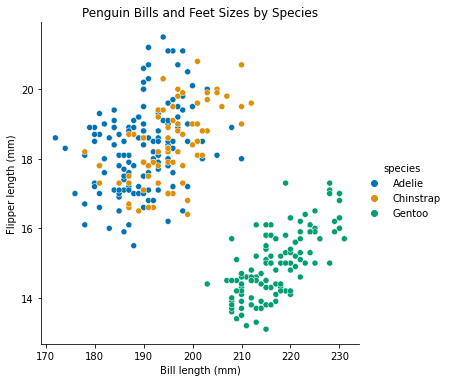

In [21]:
penguin = sns.load_dataset("penguins")
sns.relplot(x="flipper_length_mm", y="bill_depth_mm", hue= "species", data=penguins);
plt.xlabel("Bill length (mm)")
plt.ylabel("Flipper length (mm)")
plt.title("Penguin Bills and Feet Sizes by Species")

---

$k$-means clustering is an easy-to-use clustering algorithm with several common implementations, including one in the `scikit-learn` package. It works best when there are [convex](https://simple.wikipedia.org/wiki/Convex_set), roughly symmetric clusters in the data. We observe such species clusters in the scatterplot from the previous problem, so we can proceed confidently with clustering over these two measurements to identify species.

For $k$-means, we have to set the number of clusters ahead of time (the algorithm cannot learn the number of clusters from the data). Luckily, in this application, there is a natural choice: we're looking for three species clusters.

In [22]:
## initialize a KMeans object
clustering = KMeans(n_clusters = 3, random_state = 15)

## execute the KMeans algorithm on the penguins bill and flipper length data
clustering.fit(penguins[["bill_length_mm", "flipper_length_mm"]])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Uh-oh, there seems to be an error in the code above!

---

## Problem 2 (4 pts)

Describe the error message generated by the previous code cell in your own words (a sentence or two should be sufficient). Create a new dataframe called `penguins_clean` that addresses the issue causing the error (and prepares the data for clustering). `penguins_clean` should only have three columns: `species`, `bill_length_mm`, and `flipper_length_mm`. Print the first few rows of `penguins_clean` using `.head()`. 

**Confidence check:** `penguins_clean` should have 342 rows.

---

The penguins data frame has not only integer or float data but also has NA data as well. The klustering algorithm can not analyze this type of data and thus we must drop the NA values. 

In [23]:
penguins_clean = penguins[["species", "bill_length_mm", "flipper_length_mm"]]
penguins_clean = penguins_clean.dropna()
penguins_clean

,species,bill_length_mm,flipper_length_mm
0,Adelie,39.1,181.0
1,Adelie,39.5,186.0
2,Adelie,40.3,195.0
4,Adelie,36.7,193.0
5,Adelie,39.3,190.0
6,Adelie,38.9,181.0
7,Adelie,39.2,195.0
8,Adelie,34.1,193.0
9,Adelie,42.0,190.0
10,Adelie,37.8,186.0


---

## Problem 3 (2 pts)

Use the clustering code above (just before problem 1) on the two numeric variables in `penguins_clean`. Check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) of `KMeans` objects to figure out how to access the cluster centers and print the array containing them. 

Be sure to keep `random_state = 15` in the intialization of the `KMeans` object to ensure that your results will be idential to those in the solutions. ($k$-means involves some random number generation; here we're setting a consistent seed for everyone so the same numbers get "randomly" generated.)

---

In [24]:
## initialize a KMeans object
clustering = KMeans(n_clusters = 3, random_state = 15)

## execute the KMeans algorithm on the penguins bill and flipper length data
kmeans = clustering.fit(penguins_clean[["bill_length_mm", "flipper_length_mm"]])

kmeans

KMeans(n_clusters=3, random_state=15)

---

Now we have the clusters, but how do we know the clustering was successful in identifying species? And how can we quantify how successful it was in this task? We'll seek to answer these questions in the rest of the notebook.

---

## Problem 4 (4 pts)

Access the cluster labels from the `KMeans` object and save them to a variable called `cluster_labels`. Print the first 5 elements of the `cluster_labels` array.

Add a new column to the `penguins_clean` dataframe called `cluster_label` that contains the values stored in `cluster_labels`. Use `.head()` to show the first few rows of the updated `penguins_clean` dataframe.

In [25]:
cluster_labels = kmeans.labels_
cluster_labels[:5]
penguins_clean["cluster_label"] = cluster_labels

penguins_clean.head()

,species,bill_length_mm,flipper_length_mm,cluster_label
0,Adelie,39.1,181.0,0
1,Adelie,39.5,186.0,0
2,Adelie,40.3,195.0,2
4,Adelie,36.7,193.0,0
5,Adelie,39.3,190.0,0


---

## Problem 5 (4 pts)

Reproduce the scatterplot of bill length vs flipper length from earlier (with points coloured by species), except now change the point style so that a different point shape is used for each cluster label. Set the point size parameter to `80` and the point transparency parameter to `0.6` for all points, to make it easier to see the different point shapes clearly while compensating for point overlap.

To be clear, each data point should be colored by actual species, and be shaped by cluster label.

---

Text(0.5, 1.0, 'Penguin Bills and Feet Sizes by Species KMeans')

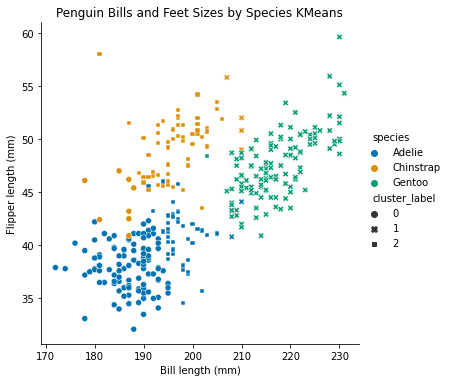

In [26]:
sns.relplot(x="flipper_length_mm", y="bill_length_mm", hue= "species", style = "cluster_label", data=penguins_clean);
plt.xlabel("Bill length (mm)")
plt.ylabel("Flipper length (mm)")
plt.title("Penguin Bills and Feet Sizes by Species KMeans")

---

By eye, it seems that our clustering quite successfully identifies the species clusters. Let's quantify the accuracy of our clustering by mapping each cluster label in `penguins_clean` to the species we believe the cluster represents, and then checking whether the known species matches the species predicted by the clustering. 

Here is a lookup table that matches the cluster labels to the majority's species in each cluster (provided you used `random_state = 15`):

In [27]:
predicted_species_lookup = pd.DataFrame({"cluster_label": [0, 1, 2],
                                        "predicted_species": ["Adelie", "Gentoo", "Chinstrap"]})
predicted_species_lookup.head()

,cluster_label,predicted_species
0,0,Adelie
1,1,Gentoo
2,2,Chinstrap


---

## Problem 6 (4 pts)

Make a new dataframe called `penguins_predict` that uses `.merge()` with the `predicted_species_lookup` table to decode the cluster labels in the `penguins_clean` data. Ensure you have not lost any observations from `penguins_predict` after the join. Print the number of rows in `penguins_predict` using a labelled string. Show the `.head()` of `penguins_predict`, which should have the following columns:

```
species | bill_length_mm | fliper_length_mm | cluster_label | predicted_species
```

---

In [28]:
penguins_predict = penguins_clean.merge(predicted_species_lookup, on = "cluster_label")

print(f"The size penguins_clean is {len(penguins_clean)} and the size of penguins_predict\
 is {len(penguins_predict)}. Thus, no data was lost.")

print(penguins_predict.head())

The size penguins_clean is 342 and the size of penguins_predict is 342. Thus, no data was lost.
  species  bill_length_mm  flipper_length_mm  cluster_label predicted_species
0  Adelie            39.1              181.0              0            Adelie
1  Adelie            39.5              186.0              0            Adelie
2  Adelie            36.7              193.0              0            Adelie
3  Adelie            39.3              190.0              0            Adelie
4  Adelie            38.9              181.0              0            Adelie


---

## Problem 7 (2 pts)

Calculate the accuracy of identifying penguin species with the clustering algorithm for the entire data set by calculating the percentage of observations where the actual species matched the species predicted by clustering. Print the result as a percentage rounded to one decimal place using a labelled string.

---

In [29]:
accuracy_count = 0
for i in penguins_predict.index:
    if penguins_predict.species[i] == penguins_predict.predicted_species[i]:
        accuracy_count += 1
print(f"The KMeans algorithm has an accuracy of {accuracy_count/len(penguins_predict.species)*100 : .1f}%.")

The KMeans algorithm has an accuracy of  83.9%.


---

Looking back at the scatterplot illustrating the clusters, it looks like some species are more reliably predicted by clustering over bill and flipper length. Let's try to quantify the accuracy of clustering by species.

---

## Problem 8 (4 pts)

Write a function called `accuracy_by_species` that takes two arguments: the species name, as a string, and a dataframe with the same structure as `penguins_predict`. The function should return the percentage of correctly classified observations (as a number) for the specified species.

Apply your function to the Adelie species of penguin in the `penguins_predict` dataset and print the accuracy rounded to one decimal place in a labelled string.

**Confidence check:** The accuracy of classifying Adelie penguins via clustering (with `random_state = 15`) should be 73.5%.

---

In [30]:
def accuracy_by_species(species_name, dataframe):
    count = 0
    for i in dataframe.index:
        if (dataframe.species[i] == species_name) and (dataframe.predicted_species[i] == species_name):
            count +=1
    print(f"{count/len(dataframe.loc[dataframe.species == species_name]) *100 :.1f}%")

accuracy_by_species("Adelie", penguins_predict)

73.5%


---

While we could certainly apply this function to each penguin species manually, it is often more efficient to use pandas to perform such repeated tasks over an entire column of values...

---

## Problem 9 (6 pts)

Create a new dataframe called `prediction_accuracy` that contains all the same information as the `predicted_species_lookup` table but features an additional column called `percent_accurate`. Generate this new column by applying the `accuracy_by_species` function written in the previous problem to the `predicted_species` column from `predicted_species_lookup` using the pandas `.apply()` [Series method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.apply.html). (Thus, the new column should contain the percentage of observations with accurately predicted species via clustering.)

Show the `prediction_accuracy` table using the `.head()` method.

**Hint:** Here is an example of `.apply()` syntax, which can be a little confusing at first:
```
## set up a data frame
df = pd.DataFrame({"a_values": [3, 6, 7]})

## define a simple function we'll apply over the "a_values" column
def my_function_name(a, b):
    return a + b

## pull out the column called "a values"
a_column = df["a_values"]

## use the apply function
a_column.apply(my_function_name, b = 5)
```

Running this code, the last line would return the a `pandas.Series` object with the entries

```
[my_function_name(a = a_column[0], b = 5),
 my_function_name(a = a_column[1], b = 5),
 my_function_name(a = a_column[2], b = 5)]
```

which in the example would simplify to 
```
[8, 11, 12]
```

In other words, `.apply()` will pass the column being "applied" over (`a_column`) as the first argument to the function being applied (`my_function_name`). Other parameters of the function being applied (`b = 5`) can be passed through `.apply()` in its subsequent (named) parameters. Note that the first argument of `.apply()` is just the function name, with no parentheses or parameters. We're just telling Python the name of the object storing the function we wish to apply.

In [58]:
prediction_accuracy = predicted_species_lookup

percent_accurate = predicted_species_lookup.predicted_species.apply(accuracy_by_species, dataframe = penguins_predict)

prediction_accuracy["percent_accurate"] = ["73.5%", "99.2%", "79.4%"]

prediction_accuracy.head()


73.5%
99.2%
79.4%


,cluster_label,predicted_species,percent_accurate
0,0,Adelie,73.5%
1,1,Gentoo,99.2%
2,2,Chinstrap,79.4%


## Problem 10 (4 pts)

The plot below shows the results of running the same clustering analysis again (with the same random seed in case you want to replicate it) except this time we have attempted to cluster species by `bill_length_mm`, and `body_mass_g`. 

![](p10-1.png)

Consider the results in the graph above (no need to compute accuracy here, but feel free). How successful do you think our clustering has been here compared to before? If you think it has been less successful, can you briefly describe why you think that might be, and how we might have forseen (from a scatter plot of the data before clustering) that applying $k$-means might not be as fruitful an analytic strategy with these variables?

The clustering in the graph was less successful than the previous one. I do not think that body mass is a good variable to run k-means on. I think that the body mass of different penguin species can vary wildly depending on what time of the year the mass was measured as well as how well the grazing period of the penguin were prior to being measured. Although I think bill length might be a better variable to tell different species apart, body mass seems to be an inconsistent variable. My observation is based mainly on the overlapping of the differnt clusters. Cluster 0 over laps across the three different species, and it shows how bad this k-means fitting was. 